In [4]:
import torch
import cv2
import numpy as np
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator

device = 'cpu'


model_type = "vit_t"
checkpoint_path = "weights/mobile_sam.pt"

sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

image_path = "test1.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(image)

for i, mask in enumerate(masks):
    segmentation = mask['segmentation'].astype(np.uint8) * 255
    cv2.imwrite(f"mask_{i}.png", segmentation)

In [6]:
# train.py
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from mobile_sam import sam_model_registry  

# Параметры
IMAGE_DIR = './Dataset/render'
MASK_DIR = './Dataset/mask'
CHECKPOINT_PATH = 'weights/mobile_sam.pt'  # Предобученные веса SAM
NUM_CLASSES = 2
BATCH_SIZE = 8
EPOCHS = 6
LR = 1e-4

# Устройство
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Датасет
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()

# Аугментация
transform = A.Compose([
    A.LongestMaxSize(max_size=1024), 
    A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=0),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Кастомная модель
class MobileSAMSegmentation(torch.nn.Module):
    def __init__(self, checkpoint_path, num_classes):
        super().__init__()
        self.backbone = sam_model_registry["vit_t"](checkpoint=checkpoint_path)
        for param in self.backbone.image_encoder.parameters():
            param.requires_grad = False  # Заморозим backbone
        self.decoder = torch.nn.Sequential(
            torch.nn.Conv2d(256, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, num_classes, kernel_size=1)
        )

    def forward(self, x):
        image_embedding = self.backbone.image_encoder(x)
        out = self.decoder(image_embedding)
        out = torch.nn.functional.interpolate(out, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        return out

def main():
    dataset = SegmentationDataset(IMAGE_DIR, MASK_DIR, transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = MobileSAMSegmentation(CHECKPOINT_PATH, NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{EPOCHS}", colour="green"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"[{epoch+1}] Loss: {running_loss / len(dataloader):.4f}")

    # Сохраняем обученную модель
    torch.save(model.state_dict(), "mobile_sam_finetuned.pth")
    print("✅ Модель сохранена как mobile_sam_finetuned.pth")

if __name__ == "__main__":
    main()


Epoch 1/6: 100%|██████████| 82/82 [03:12<00:00,  2.34s/it]


[1] Loss: 0.2903


Epoch 2/6: 100%|██████████| 82/82 [03:04<00:00,  2.25s/it]


[2] Loss: 0.0500


Epoch 3/6: 100%|██████████| 82/82 [03:02<00:00,  2.22s/it]


[3] Loss: 0.0178


Epoch 4/6: 100%|██████████| 82/82 [03:08<00:00,  2.30s/it]


[4] Loss: 0.0089


Epoch 5/6: 100%|██████████| 82/82 [03:01<00:00,  2.21s/it]


[5] Loss: 0.0053


Epoch 6/6: 100%|██████████| 82/82 [03:00<00:00,  2.21s/it]

[6] Loss: 0.0035
✅ Модель сохранена как mobile_sam_finetuned.pth


✅ Маска сохранена как output_mask.png


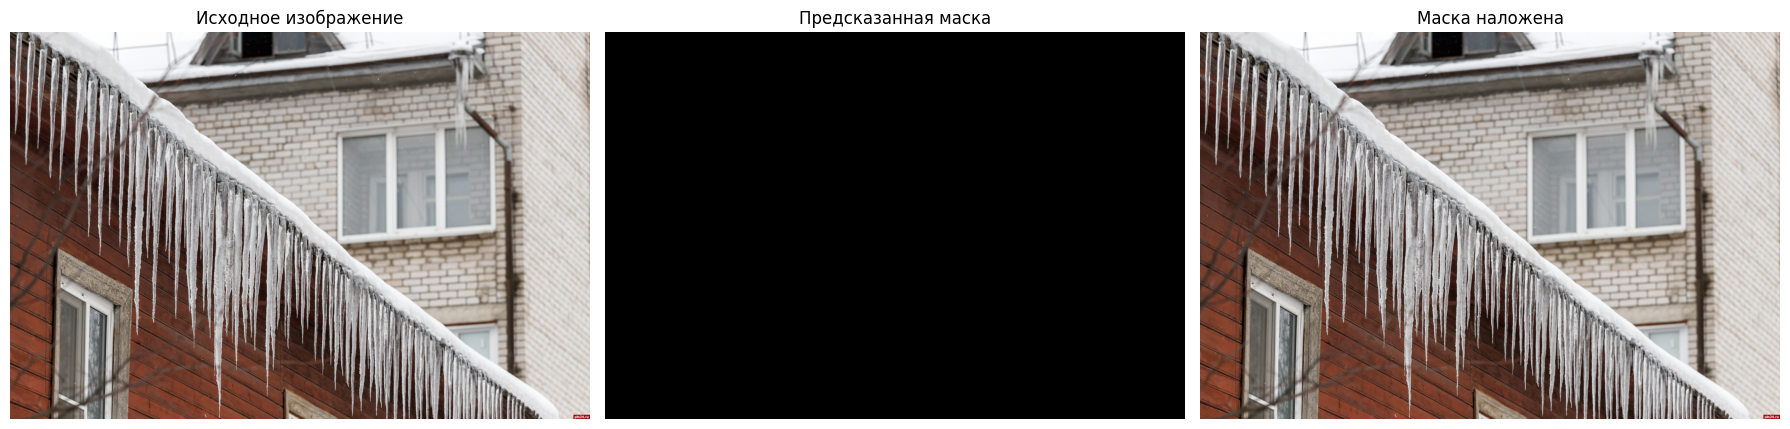

In [17]:
# inference.py
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from mobile_sam import sam_model_registry
from albumentations.pytorch import ToTensorV2
import albumentations as A

CHECKPOINT_PATH = "weights/mobile_sam.pt"
FINETUNED_WEIGHTS = "mobile_sam_finetuned.pth"
NUM_CLASSES = 2

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Аугментация
transform = A.Compose([
    A.LongestMaxSize(max_size=1024),
    A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=0),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Модель
class MobileSAMSegmentation(torch.nn.Module):
    def __init__(self, checkpoint_path, num_classes):
        super().__init__()
        self.backbone = sam_model_registry["vit_t"](checkpoint=checkpoint_path)
        for param in self.backbone.image_encoder.parameters():
            param.requires_grad = False
        self.decoder = torch.nn.Sequential(
            torch.nn.Conv2d(256, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, num_classes, kernel_size=1)
        )

    def forward(self, x):
        image_embedding = self.backbone.image_encoder(x)
        out = self.decoder(image_embedding)
        out = torch.nn.functional.interpolate(out, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        return out

def infer(image_path):
    # Загрузка и подготовка изображения
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image_rgb.shape[:2]

    augmented = transform(image=image_rgb)
    tensor_image = augmented['image'].unsqueeze(0).to(device)

    # Загрузка модели
    model = MobileSAMSegmentation(CHECKPOINT_PATH, NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(FINETUNED_WEIGHTS, map_location=device))
    model.eval()

    with torch.no_grad():
        output = model(tensor_image)
        predicted = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        predicted_resized = cv2.resize(predicted.astype(np.uint8), (original_size[1], original_size[0]), interpolation=cv2.INTER_NEAREST)

    # Сохранение маски
    mask_path = "output_mask.png"
    cv2.imwrite(mask_path, (predicted_resized * 255).astype(np.uint8))
    print(f"✅ Маска сохранена как {mask_path}")

    # Визуализация
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Исходное изображение")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_resized, cmap="gray")
    plt.title("Предсказанная маска")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    overlay = image_rgb.copy()
    overlay[predicted_resized == 1] = [255, 0, 0]  # красная маска
    plt.imshow(overlay)
    plt.title("Маска наложена")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    infer("test1.jpg")  # Заменить на путь к своему изображению


✅ Уникальные значения в маске: [0]
✅ Маска сохранена как output_mask.png


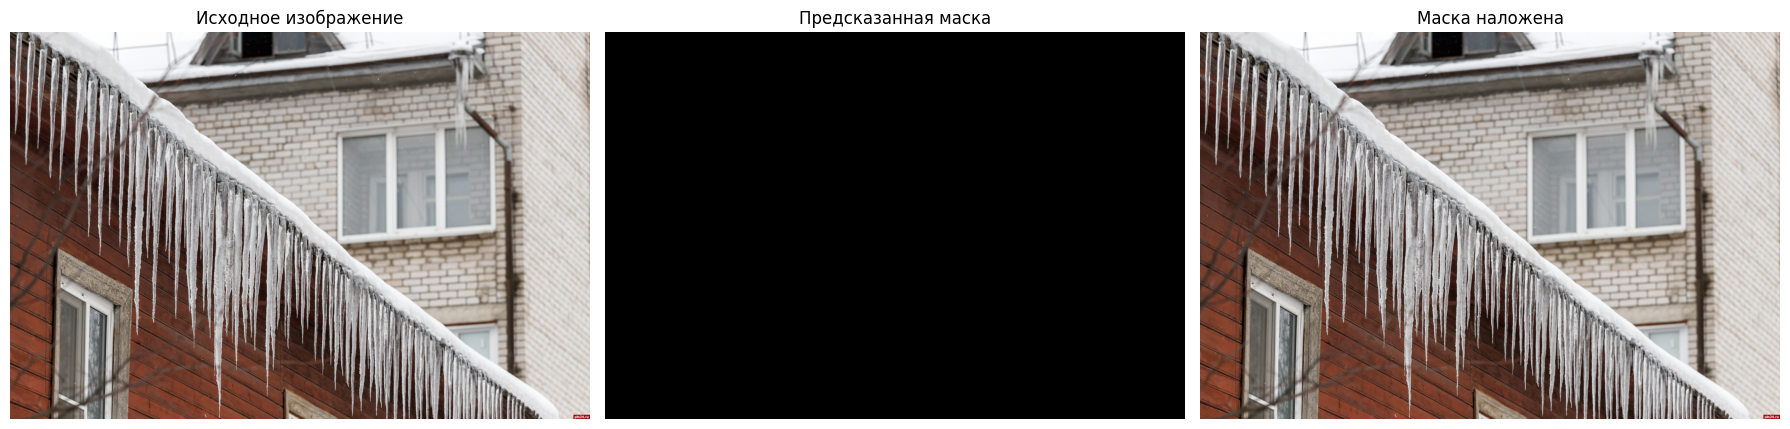

In [20]:
# inference.py

import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from mobile_sam import sam_model_registry
from albumentations.pytorch import ToTensorV2
import albumentations as A

CHECKPOINT_PATH = "weights/mobile_sam.pt"
FINETUNED_WEIGHTS = "mobile_sam_finetuned.pth"
NUM_CLASSES = 2

# Устройство
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")

# Аугментация
transform = A.Compose([
    A.LongestMaxSize(max_size=1024),
    A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=0),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Модель
class MobileSAMSegmentation(torch.nn.Module):
    def __init__(self, checkpoint_path, num_classes):
        super().__init__()
        self.backbone = sam_model_registry["vit_t"](checkpoint=checkpoint_path)
        for param in self.backbone.image_encoder.parameters():
            param.requires_grad = False
        self.decoder = torch.nn.Sequential(
            torch.nn.Conv2d(256, 128, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, num_classes, kernel_size=1)
        )

    def forward(self, x):
        image_embedding = self.backbone.image_encoder(x)
        out = self.decoder(image_embedding)
        out = torch.nn.functional.interpolate(out, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        return out

def infer(image_path):
    # Загрузка и подготовка изображения
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = image_rgb.shape[:2]

    augmented = transform(image=image_rgb)
    tensor_image = augmented['image'].unsqueeze(0).to(device)

    # Модель
    model = MobileSAMSegmentation(CHECKPOINT_PATH, NUM_CLASSES).to(device)

    # Загрузка весов
    state_dict = torch.load(FINETUNED_WEIGHTS, map_location=device)
    if "backbone.image_encoder.patch_embed.seq.0.c.weight" in state_dict:
        model.load_state_dict(state_dict)
    elif "model" in state_dict:
        model.load_state_dict(state_dict["model"])
    else:
        raise RuntimeError("❌ Не удалось загрузить веса: структура state_dict неизвестна")

    model.eval()

    # Предсказание
    with torch.no_grad():
        output = model(tensor_image)
        predicted = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        predicted_resized = cv2.resize(predicted.astype(np.uint8), (original_size[1], original_size[0]), interpolation=cv2.INTER_NEAREST)

    # Проверка значений маски
    unique_vals = np.unique(predicted_resized)
    print(f"✅ Уникальные значения в маске: {unique_vals}")

    # Сохранение
    mask_path = "output_mask.png"
    cv2.imwrite(mask_path, (predicted_resized * 255).astype(np.uint8))
    print(f"✅ Маска сохранена как {mask_path}")

    # Визуализация
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Исходное изображение")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_resized, cmap="gray")
    plt.title("Предсказанная маска")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    overlay = image_rgb.copy()
    overlay[predicted_resized == 1] = [255, 0, 0] 
    plt.imshow(overlay)
    plt.title("Маска наложена")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    infer("test1.jpg") 


In [19]:
import torch

weights = torch.load("mobile_sam_finetuned.pth", map_location="cpu")

# Если это state_dict:
if isinstance(weights, dict):
    print("Top-level keys:", list(weights.keys()))
    example_key = list(weights.keys())[0]
    print(f"🔍 Example tensor shape for '{example_key}':", weights[example_key].shape)
else:
    print("Loaded object is not a dict. Type:", type(weights))


Top-level keys: ['backbone.image_encoder.patch_embed.seq.0.c.weight', 'backbone.image_encoder.patch_embed.seq.0.bn.weight', 'backbone.image_encoder.patch_embed.seq.0.bn.bias', 'backbone.image_encoder.patch_embed.seq.0.bn.running_mean', 'backbone.image_encoder.patch_embed.seq.0.bn.running_var', 'backbone.image_encoder.patch_embed.seq.0.bn.num_batches_tracked', 'backbone.image_encoder.patch_embed.seq.2.c.weight', 'backbone.image_encoder.patch_embed.seq.2.bn.weight', 'backbone.image_encoder.patch_embed.seq.2.bn.bias', 'backbone.image_encoder.patch_embed.seq.2.bn.running_mean', 'backbone.image_encoder.patch_embed.seq.2.bn.running_var', 'backbone.image_encoder.patch_embed.seq.2.bn.num_batches_tracked', 'backbone.image_encoder.layers.0.blocks.0.conv1.c.weight', 'backbone.image_encoder.layers.0.blocks.0.conv1.bn.weight', 'backbone.image_encoder.layers.0.blocks.0.conv1.bn.bias', 'backbone.image_encoder.layers.0.blocks.0.conv1.bn.running_mean', 'backbone.image_encoder.layers.0.blocks.0.conv1.bn

# Скрипт для разделения датасета на тренировочные и валидационные части

In [16]:
import os
import shutil
import random
from pathlib import Path

image_dir = Path("Dataset/render")
label_dir = Path("Dataset/labels")

target_base = Path("Dataset_split")
target_images = target_base / "images"
target_labels = target_base / "labels"

for split in ["train", "val"]:
    (target_images / split).mkdir(parents=True, exist_ok=True)
    (target_labels / split).mkdir(parents=True, exist_ok=True)

image_paths = list(image_dir.glob("*.png"))
random.shuffle(image_paths)

split_index = int(0.8 * len(image_paths))
train_paths = image_paths[:split_index]
val_paths = image_paths[split_index:]

def copy_split(paths, split):
    for img_path in paths:
        label_path = label_dir / (img_path.stem + ".txt")
        if not label_path.exists():
            print(f"⚠️ Пропущен {img_path.name} — нет аннотации")
            continue
        shutil.copy(img_path, target_images / split / img_path.name)
        shutil.copy(label_path, target_labels / split / label_path.name)

copy_split(train_paths, "train")
copy_split(val_paths, "val")
print("✅ Разделение завершено: данные находятся в папке Dataset_split/")

✅ Разделение завершено: данные находятся в папке Dataset_split/


# Скрипт для преобразования масок в *.txt формат для работы с Yolo

In [15]:
import os
import cv2
import numpy as np
from pathlib import Path

image_dir = Path("Dataset/render")
mask_dir = Path("Dataset/mask")
output_labels_dir = Path("Dataset/labels")
output_labels_dir.mkdir(parents=True, exist_ok=True)

for mask_path in mask_dir.glob("*.png"):
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    h, w = mask.shape
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    label_lines = []
    for contour in contours:
        if len(contour) < 3:
            continue
        normalized = contour[:, 0, :].astype(float)
        normalized[:, 0] /= w
        normalized[:, 1] /= h
        flat = normalized.flatten()
        line = "0 " + " ".join(map(str, flat))
        label_lines.append(line)
    label_path = output_labels_dir / (mask_path.stem + ".txt")
    with open(label_path, "w") as f:
        f.write("\n".join(label_lines))

# Скрипт для проверки правильности преобразования масок в формат *.txt

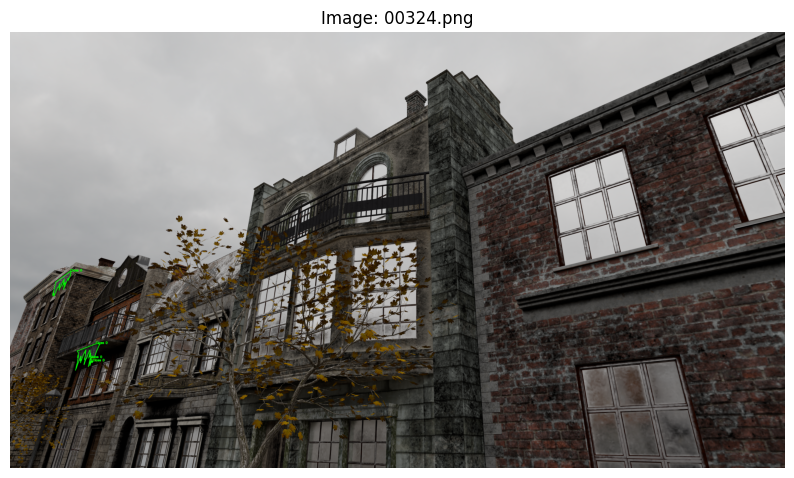

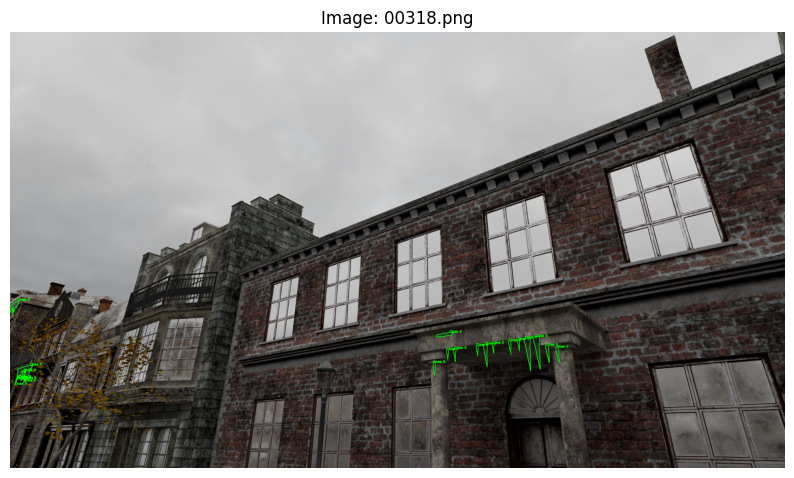

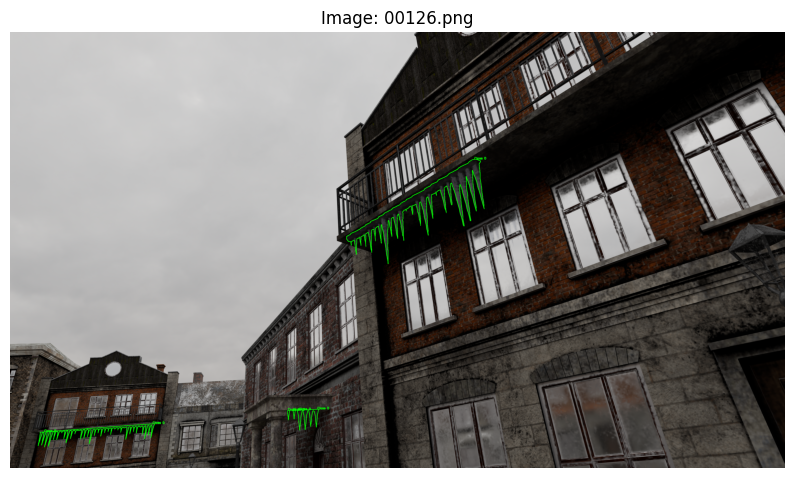

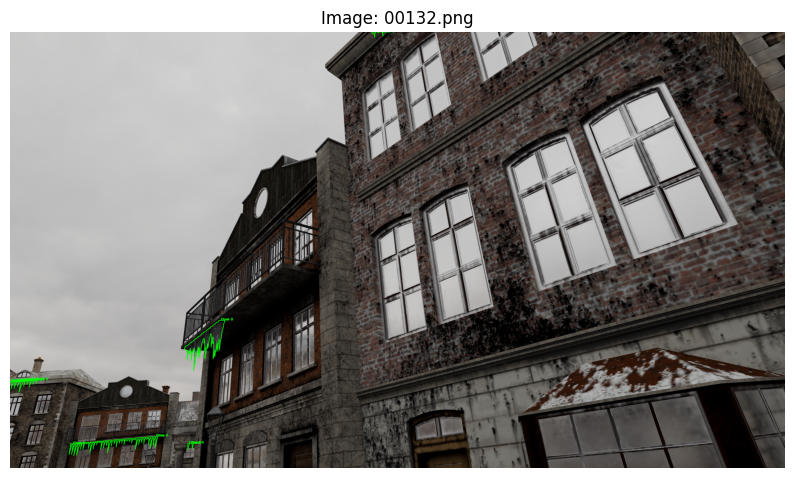

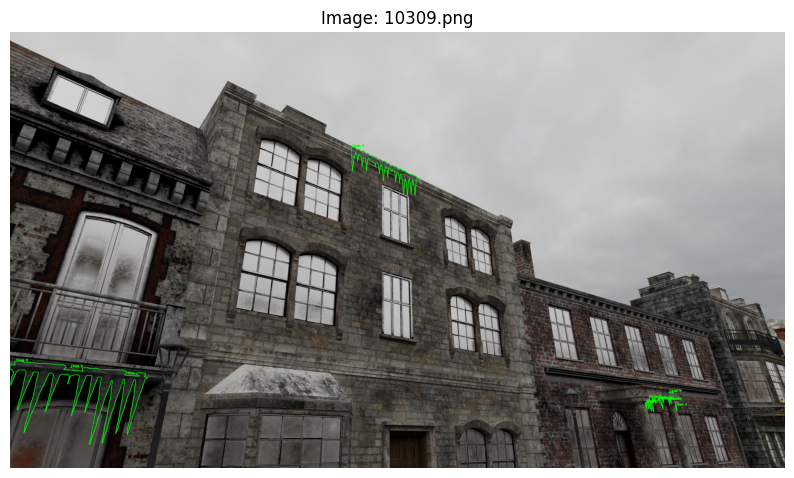

In [25]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


images_dir = "./Dataset_split/images/train" 
labels_dir = "./Dataset_split/labels/train" 

def parse_yolo_segmentation(label_path, img_width, img_height):
    polygons = []
    with open(label_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line: 
                continue
            values = line.split()
            if len(values) < 3: 
                print(f"Некорректная строка в {label_path}: {line}")
                continue
            class_id = float(values[0]) 
            coords = [float(v) for v in values[1:]]
            if len(coords) % 2 != 0:
                print(f"Ошибка: нечётное количество координат в строке {line}")
                continue
            points = [(int(coords[i] * img_width), int(coords[i+1] * img_height)) 
                      for i in range(0, len(coords), 2)]
            polygons.append((class_id, points))
    return polygons

def visualize_image_with_masks(img_path, label_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Не удалось загрузить изображение: {img_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width = img.shape[:2]
    polygons = parse_yolo_segmentation(label_path, img_width, img_height)
    for class_id, points in polygons:
        pts = np.array(points, np.int32).reshape((-1, 1, 2))
        cv2.polylines(img, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
        if points: 
            cv2.putText(img, f"Class {int(class_id)}", points[0], 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {os.path.basename(img_path)}")
    plt.show()

for i, img_file in enumerate(os.listdir(images_dir)):
    if i >= 5:
        break
    if img_file.endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(images_dir, img_file)
        label_path = os.path.join(labels_dir, img_file.replace(img_file.split('.')[-1], 'txt'))
        if not os.path.exists(label_path):
            print(f"Файл аннотации не найден для {img_file}")
            continue
        visualize_image_with_masks(img_path, label_path)